# CmCt: Glacier Comparison

<code style="color : Orange"> Welcome! This notebook can be used to compare glacier model outputs to observation datasets to access model accuracy. Accepted models are OGGM models and XX. Available observation datasets are Dussaillant et al's Mass change dataset from 2025, Hugonnet et al's Mass change and elevation change dataset from 2021, and Reference glacier's mass change dataset. Glaciers are identified in The Randolph Glacier Inventory (RGI 6.0) for all comparisons. </code>

<code style="color : Orange"> To perform a comaprison, follow the following steps:</code> 

Quick Description of each cell:     
Cell [1]: Import Cell – Loads all required libraries. Always run first after opening the notebook or restarting the kernel.  
Cell [2]: Region Selection – Select regions of interest for analysis. Run if selecting regions for the first time or changing regions.  
Cell [3]: Model/Scenario/Observation Selection – Choose datasets for model outputs, scenarios, and observation datasets (via dropdowns).  
Cell [4]: Process Model Output – Processes selected model outputs. Choose "Run Model Cleaning" (first time or with new models) or "Load Existing CSV" (to use previously processed data and save time).  
Cell [5]: Process Observation Data – Processes the selected observation dataset.  
Cell [6]: Model vs Observation Comparison – Runs comparison between model output and observations.  
Cell [7]: Aggregate Regions (Optional) – Creates a map overview.  
Cell [8]: Aggregate Regions (Optional) - Creates an aggregated time series comparison plot.  
Cell [9]: Plotting – Generates model diagnostics and comparison plots (per region or glacier).  

`What are you doing?`

1. **First Time Running Notebook?**
   - YES → Run cells: **[1] → [2] → [3] → [4] (Select: Run Model Cleaning) → [5] → [6] → [7]\* → [9]**
   - NO → Go to question 2.

2. **Same Regions & Models but New Observation Dataset?**
   - YES → **[3] (Select new dataset)** → Run cells: **[4] (Select: Load Existing CSV) → [5] → [6] → [7,8]\* → [9]**
   - NO → Go to question 3.

3. **Kernel Restarted but Same Regions & Models?**
   - YES → Run cells: **[1] → [2] → [3] → [4] (Load Existing CSV) → [5] → [6] → [7,8]\* → [9]**
   - NO → Go to question 4.

4. **Different Regions or Models?**
   - YES → **[3] (Select new datasets)** → Run cells: **[4] (Select: Run Model Cleaning) → [5] → [6] → [7,8]\* → [9]**
   - NO → Go to question 5.

5. **Different Regions or Models AND Kernel Restarted?**
   - YES → **Same as First Time Running:**  
     **[1] → [2] → [3] → [4] (Run Model Cleaning) → [5] → [6] → [7,8]* → [9]**

\* **[7][8] is only required if the observation dataset is not Reference Glaciers.**

\* **For all celles, follow the `action` notes when running.**


### Reference for each observation dataset;  
`Dussaillant et al's Mass change dataset from 2025`: Dussaillant, I., Hugonnet, R., Huss, M., Berthier, E., Bannwart, J., Paul, F., and Zemp, M. (2025): Annual mass-change estimates for the world’s glaciers. Individual glacier time series and gridded data products. Digital media. https://doi.org/10.5904/wgms-amce-2025-02b

`Hugonnet et al's Mass change and elevation change dataset from 2021`: Hugonnet, R., McNabb, R., Berthier, E. et al. Accelerated global glacier mass loss in the early twenty-first century. Nature 592, 726–731 (2021). https://doi.org/10.1038/s41586-021-03436-z

`Reference Glaciers`: WGMS (2025): Fluctuations of Glaciers (FoG) Database. World Glacier Monitoring Service (WGMS); Zurich; Switzerland. https://doi.org/10.5904/wgms-fog-2025-02b



### Requirements for Uploading own dataset outside of OGGM Model outputs
<code style="color : Orange"> -- ASSUMPTIONS & DATA REQUIREMENTS -- </code>
1. **CSV UPLOADS (source_type == "Upload")**
 - File type: One or more .csv files.
 - Data format: Annual time series data only (sub-annual data not supported).
 - Required columns (minimum):
       '`region`'       -> Region code for each glacier entry. Only numbers, either 1 or 01. No RGI01. 
       '`rgi_id`'       -> Unique glacier identifiers.
       '`volume`'       -> Glacier volume values (for dmdt calculation). **kg**
       '`area`'         -> Glacier area values (for dhdt calculation). **m^2**
       '`calendar_year`' OR/AND 'hydro_year' -> One must be present (annual temporal resolution).
 - Optional columns:
       '`model`'        -> Model name. If missing, defaults to 'custom'. 
       '`scenario`'     -> Scenario name. If missing, defaults to 'custom'. 
 - Wide format support:
       Years can be provided as column headers (e.g., 2000, 2001, 2002...).
       Data will be automatically converted from wide to long format.
 - Auto-conversion:
       If only '`hydro_year`' exists, '`calendar_year`' is generated (hydro_year - 1).
       If only '`calendar_year`' exists, '`hydro_year`' is generated (calendar_year + 1).
       Region codes are standardized to 2-digit format (e.g., '1' -> '01').
 - Filtering:
       If multiple models/scenarios exist, data is filtered by selected_model_text & selected_scenario_text.
       If only one unique model/scenario exists, all data is used regardless of user selection.
       Data is then processed for each region in selected_regions.

2. **NETCDF FILES (source_type == "Link")**
 - File type: A directory containing multiple .nc files.
 - Data format: Annual time series data only.
 - File naming format:
       Filenames must contain the model and scenario as parts [5] and [6] when split by "_".
       Example: some_output_run_v1_2000_modelA_historical_RGI01.nc
                parts[5] = "modelA", parts[6] = "historical".
       Region identification: Region string (e.g., "01", "02") must be in the filename.
 - Variables inside .nc files:
       '`volume`'  -> Glacier volume (time × rgi_id) - annual values. **kg**
       '`area`'    -> Glacier area (time × rgi_id) - annual values. **m^2**
       '`time`'    -> Represents calendar_year (annual temporal resolution).
       '`rgi_id`'  -> Glacier identifiers.
 - Filtering:
       Only files matching (selected_model_text, selected_scenario_text) are processed.
       Regions are identified by checking if zero-padded region string is in the filename.

 - All region codes are standardized to 2-digit zero-padded format for consistency.

 ❗️ Variable names must match exactly. 




## Import [1]

In [2]:
import gc
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from IPython.display import display
import requests
from bs4 import BeautifulSoup
import glob
import os
import xarray as xr
import pandas as pd
import numpy as np
from collections import defaultdict
import tempfile
import urllib.request
import zipfile
import plotly.express as px
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from jupyter_dash import JupyterDash
import importlib
import json
import geopandas as gpd
import io

## Region Selection [2]
<code style="color : red">Action</code> -> Specify which RGI6 regions you would like to compare between observation data and model output 

RGI6 documentation: https://www.glims.org/RGI/randolph60.html

**For reference**;
01_alaska,
02_western_canada_usa,
03_arctic_canada_north,
04_arctic_canada_south,
05_greenland_periphery,
06_iceland,
07_svalbard_jan_mayen,
08_scandinavia,
09_russian_arctic,
10_north_asia,
11_central_europe,
12_caucasus_middle_east,
13_central_asia,
14_south_asia_west,
15_south_asia_east,
16_low_latitudes,
17_southern_andes,
18_new_zealand,
19_subantarctic_antarctic_islands





In [7]:
#[2]
# Specify out of the 19 RGI6 regions
#selected_regions = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19"]

selected_regions = ["06"] 
selected_regions.sort()



## Select which model and observation dataset you would like to compare against [3]
<code style="color : red">Action</code> -> Specify which gcm, scenario and observation dataset you would like to compare against. If no selection is made, default values are ACCESS-CM2_ssp126 compared against mass change from the Hugonnet dataset.

Description of observation datasets;  


**Mass change (Dussaillant, 2025):** Temporal resolution is annual. Output plots include annual time series comparison, 5-year rolling average time series, residuals, residual percentage, and rmse per region. Index is hydrological years.

Data link: https://essd.copernicus.org/articles/17/1977/2025/essd-17-1977-2025.pdf

**Mass change and Elevation change (Hugonnet, 2021):** Temportal resolution is 5 years. Output plots include 5-year average time series comparison, residuals, residual percentage, and rmse per region. Index is calendar years.

Data link: https://www.sedoo.fr/theia-publication-products/?uuid=c428c5b9-df8f-4f86-9b75-e04c778e29b9

**Reference Glaceirs:** Individual glacier mass change comparison. Outpus plot include time sereies comparison and residuals. No global comaprison. Index is calendar years.

Data link: Mass balance dataset from https://wgms.ch/data_databaseversions/. Filtered out for reference glaciers corresponding to https://wgms.ch/products_ref_glaciers/. 


❗️ If uploading own dataset outside of OGGM model; 
- Define:
    - source_type: Either "Upload" (CSV) or "Link" (.nc files).
    - selected_model_text: The model name to process (e.g., "custom_model").
    - selected_scenario_text: The scenario name to process (e.g., "historical").
        -> The script processes only data matching (selected_model_text, selected_scenario_text). Refer to "filtering" in the ASSUMPTIONS & DATA REQUIREMENTS for more.


In [8]:
%run model_selection_test.ipynb 
# specify what model and scenario means



Dropdown(description='Model:', options=('ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', …

Dropdown(description='Scenario:', layout=Layout(display='block'), options=('ssp126', 'ssp585'), value='ssp126'…

Dropdown(description='Observation:', options=('Mass Change (Hugonnet, 2021, 5-year period)', 'Mass Change (Dus…

Text(value='', description='Custom Model:', layout=Layout(display='none'), placeholder='Enter custom model nam…

Text(value='', description='Custom Scenario:', layout=Layout(display='none'), placeholder='Enter custom scenar…

ToggleButtons(description='Custom Source:', layout=Layout(display='none'), options=('Upload', 'Link'), style=T…

FileUpload(value=(), accept='.csv', description='Upload', layout=Layout(display='none'))

Text(value='', description='Data URL:', layout=Layout(display='none'), placeholder='Enter folder URL')

## Preprocess selected model output [4]

<code style="color : red">Action</code> -> Set where you would like the comparison csvs to be saved in `output_summary_csv` and `reference_glaciers_output_path`. For each region run, the tool will scan for reference glaciers in that region and save them seperately, even if not directly used in that comparison run.

<code style="color : red">Action</code> -> Select if you want to (re)run the model cleaning process.   
 -- Select "Run model cleaning" if you are running analysis on new sets of regions or a new model. Select "read existing csv" only if you are using the same combination of model and regions. Thus, "read existing csv" can be used when switching between observation datasets for the same regions and models. 

⭐️ A print of "Summary statistics saved to {output_summary_csv}" is the indicator that the code has fully ran.


✅ Overview of calculations
 - Mass change (dmdt):
       `dmdt` = Δvolume * 900 (kg/m³) / 1e12  -> Gt/year (annual differences).
 - Elevation change (dhdt):
       `dhdt` = Δvolume / area                -> m/year (annual differences).
 - 5-Year Averages:
       Data is grouped into 5-year blocks based on calendar_year.
       The average dmdt and dhdt are assigned to the last year of each block.
       All other years within the block are set to NaN for these averages.
       A 'calendar_year_5yr' column marks the years with 5-year averages.
 - Reference Glacier Tracking:
       Individual glacier data for reference glaciers is saved separately.
       RGI IDs by region are tracked and exported for comparison workflows.

✅ Ouput
 - The final summary_df contains:
       '`calendar_year`', '`hydro_year`', '`dmdt`', '`dhdt`',
       '`dmdt_5yr_avg`', '`dhdt_5yr_avg`', '`calendar_year_5yr`',
       '`model`', '`scenario`', '`region`'.
 - Additional outputs:
       Reference glacier data saved to reference_glaciers_output_path.
       RGI IDs by region exported to JSON for downstream compatibility.
 

In [ ]:
output_summary_csv = "comparison_csv/oggm_output_cleaning.csv"
reference_glaciers_output_path = 'reference_glacier/reference_glaciers.csv'

selected_model = model_dropdown.value

if selected_model == "Other":
    selected_model_text = custom_model_text.value
    selected_scenario_text = custom_scenario_text.value
else: 
    selected_scenario = scenario_dropdown.value

observation_dataset = observation_dropdown.value

source_type = custom_source_toggle.value
if file_upload.value:
    # Handle both single and multiple file uploads
    if isinstance(file_upload.value, tuple):
        uploaded_file = list(file_upload.value)  # Convert tuple to list of all files
    else:
        uploaded_file = [file_upload.value]  # Single file as a list
else:
    uploaded_file = None
link_path = link_input.value if source_type == "Link" else None

cleaning_buttons = widgets.ToggleButtons(
    options=["Run Model Cleaning", "Read Existing CSV"],
    description="Model Cleaning:",
    button_style='success',
    layout=widgets.Layout(width='auto'),
    style={'description_width': 'initial'},
    value=None
)
output = widgets.Output()
display(cleaning_buttons, output)

def on_cleaning_change(change):
    with output:
        output.clear_output()
        global all_rgi_ids_by_region  # ensure you use the global variable
        if change['new'] == "Run Model Cleaning":
            print("Running model cleaning...")
            if selected_model == "Other":
                exec(open("other_cleaning.py").read(), globals())
            else:
                exec(open("oggm_output_cleaning_hugonnet.py").read(), globals())
        elif change['new'] == "Read Existing CSV":
            summary_df = pd.read_csv("comparison_csv/oggm_output_cleaning.csv", dtype={'region': str})
            print("Loaded existing CSV.")
            # Check if all_rgi_ids_by_region is not in memory
            if 'all_rgi_ids_by_region' not in globals() or all_rgi_ids_by_region is None:
                try:
                    with open("comparison_csv/all_rgi_ids_by_region.json", "r") as f:
                        all_rgi_ids_by_region = {region: set(rgi_ids) for region, rgi_ids in json.load(f).items()}
                    print("Loaded RGI IDs by region from JSON.")
                except Exception as e:
                    print(f"Could not load RGI IDs by region: {e}")

cleaning_buttons.observe(on_cleaning_change, names='value')

ToggleButtons(button_style='success', description='Model Cleaning:', layout=Layout(width='auto'), options=('Ru…

Output()

## Preprocess observation data [5]
<code style="color : red">Action</code> -> Set `local_zip` & `extract_dir`.  
-- This refers to were the dussailant data is/will be downloaded. If data is not downloaded, specify where you want it to be downloaded. If it is downloaded, specify where it is downloaded. Set the path regardless of running the dussailant_data comparisson, as the dataset will be used for global comparison as well. **Do not need to change if no directory modifications have been made.**

<code style="color : red">Action</code> -> Set `base_dir` if using the Hugonnet dataset for comparison.  
-- This referes to were the hugonnet data is stored. **Do not need to change if no directory modifications have been made.**



❗️ Note that region 12 is indexed using GLIMS ID for both the dussailant dataset and hugonnet dataset. The following [Conversion file](12_GLIMSId_RGIId_dict.csv) was used to convert between GLIMS and RGI6. However, only 1293 glaciers were sucessfully converted. The remaining 595 glaciers were omitted.

❗️ Only glaciers that were found in the model output is processed from the observation dataset.



In [5]:
#observation_dataset = 'Mass Change (Dussaillant, 2025, annual)'
local_zip = "dussailant_data/wgms-amce-2025-02b.zip"
extract_dir = "dussailant_data"

if observation_dataset == 'Mass Change (Dussaillant, 2025, annual)':
    exec(open("observation_data_cleaning.py").read(), globals())
elif observation_dataset in [
    'Mass Change (Hugonnet, 2021, 5-year period)',
    'Elevation Change (Hugonnet, 2021, 5-year period)'
]:
    base_dir = "hugonnet_timeseries"
    exec(open("observation_cleaning_hugonnet.py").read(), globals())
elif observation_dataset == 'Reference Glaciers':
    csv_path = 'reference_glacier/mass_balance.csv'
    csv_path_conversion = 'reference_glacier/glacier.csv'
    exec(open("reference_glacier.py").read(), globals())

Filtered dataset saved to reference_glacier/filtered_reference_glaciers.csv


<string>:117: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
<string>:132: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


## Combine both datasets for comparison and calculate residuals [6]

<code style="color : red">Action</code> -> Set where you would like the comparison csv to be stored (`model_outout_csv`).

<code style="color : red">Action</code> -> Set the file path for where you want the csv file to be exported (`output_file_comparison`).

In [6]:
model_output_csv = "comparison_csv/oggm_output_cleaning.csv"
# Load the cleaned model output

region_comparison = []

if observation_dataset != 'Reference Glaciers':
    for rgi_id in selected_regions:
        print(f"Processing region {rgi_id}")
        
        # Filter data for the current region
        df_all_region = df_all[df_all['region'] == rgi_id]
        summary_df_region = summary_df[summary_df['region'] == rgi_id]
    

        if df_all_region.empty:
            print(f"No observations found for region {rgi_id}. Skipping.")
            continue
        if summary_df_region.empty:
            print(f"No model outputs found for region {rgi_id}. Skipping.")
            continue

        # Common years 
        if observation_dataset == 'Mass Change (Dussaillant, 2025, annual)':
            obs_years = set(df_all_region['hydro_year'].unique())
            model_years = set(summary_df_region['hydro_year'].unique())
            df_obs = df_all_region.rename(columns={'hydro_year': 'year'}).set_index('year')
            df_model = summary_df_region.rename(columns={'hydro_year': 'year'}).set_index('year')

        elif observation_dataset in [
            'Mass Change (Hugonnet, 2021, 5-year period)',
            'Elevation Change (Hugonnet, 2021, 5-year period)'
        ]:
            obs_years = set(df_all_region['calendar_year'].unique())
            model_years = set(summary_df_region['calendar_year_5yr'].unique())
            df_obs = df_all_region.rename(columns={'calendar_year': 'year'}).set_index('year')
            df_model = summary_df_region.rename(columns={'calendar_year_5yr': 'year'}).set_index('year')

        common_years = sorted(obs_years & model_years)
        all_years = sorted(obs_years | model_years)
        #print(f"Common years between model and observation data: {', '.join(map(str, common_years))}")
        all_years = [y for y in all_years if pd.notnull(y)]
        
        merged = pd.DataFrame(index=all_years)
        merged.index.name = 'year'
        merged = merged.join(df_obs, how='left', rsuffix='_obs').join(df_model, how='left', rsuffix='_model')
        #merged.rename(columns={'mass_change': 'observation_value', 'total_mass_change': 'model_value'}, inplace=True)

        # Compute residuals only for common years
        if observation_dataset == 'Mass Change (Dussaillant, 2025, annual)':
            merged = merged.rename(columns={
                'dmdt': 'observation_value',
                'dmdt_model': 'model_value',
                'dmdt_ci_lower': 'ci_lower',
                'dmdt_ci_upper': 'ci_upper'
            })
        elif observation_dataset == 'Mass Change (Hugonnet, 2021, 5-year period)':
            merged = merged.rename(columns={
                'dmdt': 'observation_value',
                'dmdt_5yr_avg_calendar': 'model_value',
                'dmdt_ci_lower': 'ci_lower',
                'dmdt_ci_upper': 'ci_upper'
            })
        elif observation_dataset == 'Elevation Change (Hugonnet, 2021, 5-year period)':
            merged = merged.rename(columns={
                'dhdt': 'observation_value',
                'dhdt_5yr_avg_calendar': 'model_value',
                'dhdt_ci_lower': 'ci_lower',
                'dhdt_ci_upper': 'ci_upper'
            })
        
        merged['residual'] = np.nan
        merged.loc[common_years, 'residual'] = (
            merged.loc[common_years, 'observation_value'] - merged.loc[common_years, 'model_value']
        )

        # Compute RMSE only for common years
        rmse_value = np.sqrt(np.mean(merged.loc[common_years, 'residual']**2))
        merged['rmse'] = np.nan
        merged.loc[common_years, 'rmse'] = rmse_value
        # Residual percentage for common years
        merged['residual_percentage'] = np.nan
        merged.loc[common_years, 'residual_percentage'] = (
            (merged.loc[common_years, 'residual'] / merged.loc[common_years, 'observation_value']) * 100
        )

        # Model within observation CI
        merged['model_within_obs_CI'] = np.nan
        merged.loc[common_years, 'model_within_obs_CI'] = (
            (merged.loc[common_years, 'model_value'] >= merged.loc[common_years, 'ci_lower']) &
            (merged.loc[common_years, 'model_value'] <= merged.loc[common_years, 'ci_upper'])
        )

        # Rolling averages for the full time series
        if observation_dataset == 'Mass Change (Dussaillant, 2025, annual)':
            merged = merged.sort_values("year")
            merged['obs_rolling_avg'] = merged['observation_value'].rolling(window=5, min_periods=1).mean()
            merged['output_rolling_avg'] = merged['model_value'].rolling(window=5, min_periods=1).mean()
            merged['residual_rolling_avg'] = merged['obs_rolling_avg'] - merged['output_rolling_avg']

            rolling_se = merged['std'].rolling(window=5, min_periods=1).mean()
            merged['rolling_CI_upper'] = merged['obs_rolling_avg'] + 1.96 * rolling_se
            merged['rolling_CI_lower'] = merged['obs_rolling_avg'] - 1.96 * rolling_se

        # Add region column
        merged['region'] = rgi_id

        region_comparison.append(merged.reset_index())
elif observation_dataset == 'Reference Glaciers':
    obs_df = filtered_dataset.rename(columns={'calendar_year': 'year'})
    model_df = reference_df.rename(columns={'calendar_year': 'year'})

    # Find common glaciers
    common_ids = set(model_df['rgi_id']).intersection(set(obs_df['rgi_id']))
    print(f"Found {len(common_ids)} reference glaciers in both datasets.")

    # Filter both datasets
    model_filtered = model_df[model_df['rgi_id'].isin(common_ids)]
    obs_filtered = obs_df[obs_df['rgi_id'].isin(common_ids)]
    model_years = set(model_filtered['year'].unique())

    all_years = pd.DataFrame({'year': range(2000, max(model_df['year'].max(), obs_df['year'].max()) + 1)})

    region_comparison = []
    for gid in common_ids:
        # Select glacier-specific data
        model_g = model_df[model_df['rgi_id'] == gid].copy()
        obs_g = obs_df[obs_df['rgi_id'] == gid].copy()

        # Merge each dataset with the complete year range
        model_g = pd.merge(all_years, model_g, on='year', how='left')
        obs_g = pd.merge(all_years, obs_g, on='year', how='left')

        # Add glacier ID
        model_g['rgi_id'] = gid
        obs_g['rgi_id'] = gid

        # Merge model and observation datasets
        merged = pd.merge(
            model_g,
            obs_g,
            on=['rgi_id', 'year'],
            suffixes=('_model', '_obs'),
            how='outer'
        )

        # Calculate residual (will be NaN if observation or model data is missing)
        merged['residual'] = merged['dmdt_model'] - merged['dmdt_obs']

        region_comparison.append(merged)

# Export the comparison DataFrames for each region as a csv
comparison_df = pd.concat(region_comparison, ignore_index=True)

output_file_comparison = "comparison_csv/model_observation_comparison.csv" #set
os.makedirs(os.path.dirname(output_file_comparison), exist_ok=True)

comparison_df.to_csv(output_file_comparison, index=False)
print(f"Comparison DataFrame exported to {output_file_comparison}")


Found 8 reference glaciers in both datasets.
Comparison DataFrame exported to comparison_csv/model_observation_comparison.csv


## Visual comparison of residual percentage by region on global map (None for Reference Glaciers) [7]
Color coded by regional residual percentage (Divided by observation value). Hover over region to see year, region code, and residual percentage. Use slide bar to see temporal change. Click on a region to pull up a quick view of time series comparison. In order to change the extent shown in the time series, change value for `max_year`.

<code style="color : red">Action</code> -> Set file path for where the RGI6 shapefile is stored (`shapefile_path`).

In [7]:
if observation_dataset != 'Reference Glaciers':
    max_year = 2050 # can set 

    # Set the maximum year for the plot
    shapefile_path = 'global_comparison_shapefile/00_rgi60_O1Regions.shp'

    if not os.path.isfile(local_zip):
        os.makedirs(os.path.dirname(local_zip), exist_ok=True)
        print("Downloading WGMS AMCE dataset...")
        urllib.request.urlretrieve(data_url, local_zip)

        # Unzip
        print("Extracting files...")
        with zipfile.ZipFile(local_zip, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        print(f"Data downloaded and extracted to {extract_dir}")


    exec(open("global_comparison.py").read(), globals())

    region_mask = ds['region_mask'].values  # (lat, lon)
    years = ds['time'].values 
    if hasattr(years[0], 'year'):
        years = np.array([y.year for y in years])

    # Prepare 3D array: (time, lat, lon)
    resid_cube = np.full((len(common_years), *region_mask.shape), np.nan)

    for t, year in enumerate(common_years):
        region_resid = comparison_df[comparison_df['year'] == year][['region', 'residual_percentage']]
        region_to_resid = dict(zip(region_resid['region'], region_resid['residual_percentage']))
        for region, resid in region_to_resid.items():
            resid_cube[t][region_mask == region] = resid

    # Get grid of lon/lat
    lons, lats = np.meshgrid(ds['lon'].values, ds['lat'].values)

    plot_df = pd.DataFrame({
        'lon': lons.ravel(),
        'lat': lats.ravel(),
        'region_code': region_mask.ravel()
    })

    frames = []
    for t, year in enumerate(common_years):
        frame = plot_df.copy()
        frame['residual_percentage'] = resid_cube[t].ravel()
        frame['year'] = year
        frames.append(frame)

    plotly_df = pd.concat(frames, ignore_index=True)


    vmin = plotly_df['residual_percentage'].quantile(0.25)
    vmax = plotly_df['residual_percentage'].quantile(0.75)


    fig_map = px.scatter_geo(
        plotly_df.dropna(subset=['residual_percentage']),
        lat='lat',
        lon='lon',
        color='residual_percentage',
        animation_frame='year',
        color_continuous_scale='RdBu',
        range_color=[vmin, vmax],
        title='Residual Percentage by Region (Slider by Year)',
        opacity=1.0,
        hover_data={
            'year': True,
            'region_code': True,
            'residual_percentage': True,
            'lat': False,
            'lon': False
        },
        custom_data=['region_code']
    )
    fig_map.update_layout(margin=dict(l=0, r=0, t=30, b=30), height=500, width=800)
    fig_map.update_traces(marker=dict(size=6, symbol='square'))  
    #fig_map.update_geos(showcoastlines=True, fitbounds="locations")

    app = JupyterDash(__name__)
    app.layout = html.Div([
        dcc.Graph(id='map-plot', figure=fig_map),
        dcc.Graph(id='timeseries-plot', style={'height': '500px', 'width': '800px'})
    ])

    @app.callback(
        Output('timeseries-plot', 'figure'),
        Input('map-plot', 'clickData')
    )
    def update_timeseries(clickData):
        if clickData is None:
            return go.Figure().update_layout(title="Select a region on the map")
        region_code = clickData['points'][0]['customdata'][0]
        region_df = comparison_df[comparison_df["region"] == region_code]
        region_df.loc[~region_df['year'].isin(obs_years), 'observation_value'] = np.nan
        region_df.loc[~region_df['year'].isin(model_years), 'model_value'] = np.nan
        observation_only_years = sorted(set(region_df['year'].dropna()) & set(region_df.dropna(subset=['model_value'])['year']))
        region_df = region_df[region_df['year'].isin(observation_only_years)]

        region_df = region_df[region_df['year'] <= max_year] 

        if region_df.empty:
            return go.Figure().update_layout(title=f"No data for region {region_code}")

        
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=region_df["year"],
            y=region_df["observation_value"],
            mode='lines+markers',
            name='Observed'
        ))
        fig.add_trace(go.Scatter(
            x=region_df["year"],
            y=region_df["model_value"],
            mode='lines+markers',
            name='Modeled'
        ))
        fig.add_trace(go.Scatter(
            x=region_df["year"],
            y=region_df["ci_upper"],
            mode='lines',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip'
        ))
        fig.add_trace(go.Scatter(
            x=region_df["year"],
            y=region_df["ci_lower"],
            mode='lines',
            fill='tonexty',
            fillcolor='rgba(128,128,128,0.3)',
            line=dict(width=0),
            showlegend=True,
            name='95% CI',
            hoverinfo='skip'
        ))
        fig.add_trace(go.Scatter(
        x=region_df["year"],
        y=region_df["residual"],
        mode='lines+markers',
        name='Residuals',
        line=dict(dash='dash', color='purple')
        ))
        fig.update_layout(
            title=f"Mass Change Time Series for Region {region_code}",
            xaxis_title="Year",
            yaxis_title="Gt/year"
        )
        return fig

    app.run(mode='inline')  # For Jupyter

## Global Aggregated Time Series Plot (None for reference glaciers) [8]
⭐️ In order to change the extent shown in the time series, change value for `max_year`.


/var/folders/x6/3h_s_nvj4db2vtjy6w27qt400000gn/T/ipykernel_6425/907869437.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/x6/3h_s_nvj4db2vtjy6w27qt400000gn/T/ipykernel_6425/907869437.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/x6/3h_s_nvj4db2vtjy6w27qt400000gn/T/ipykernel_6425/907869437.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

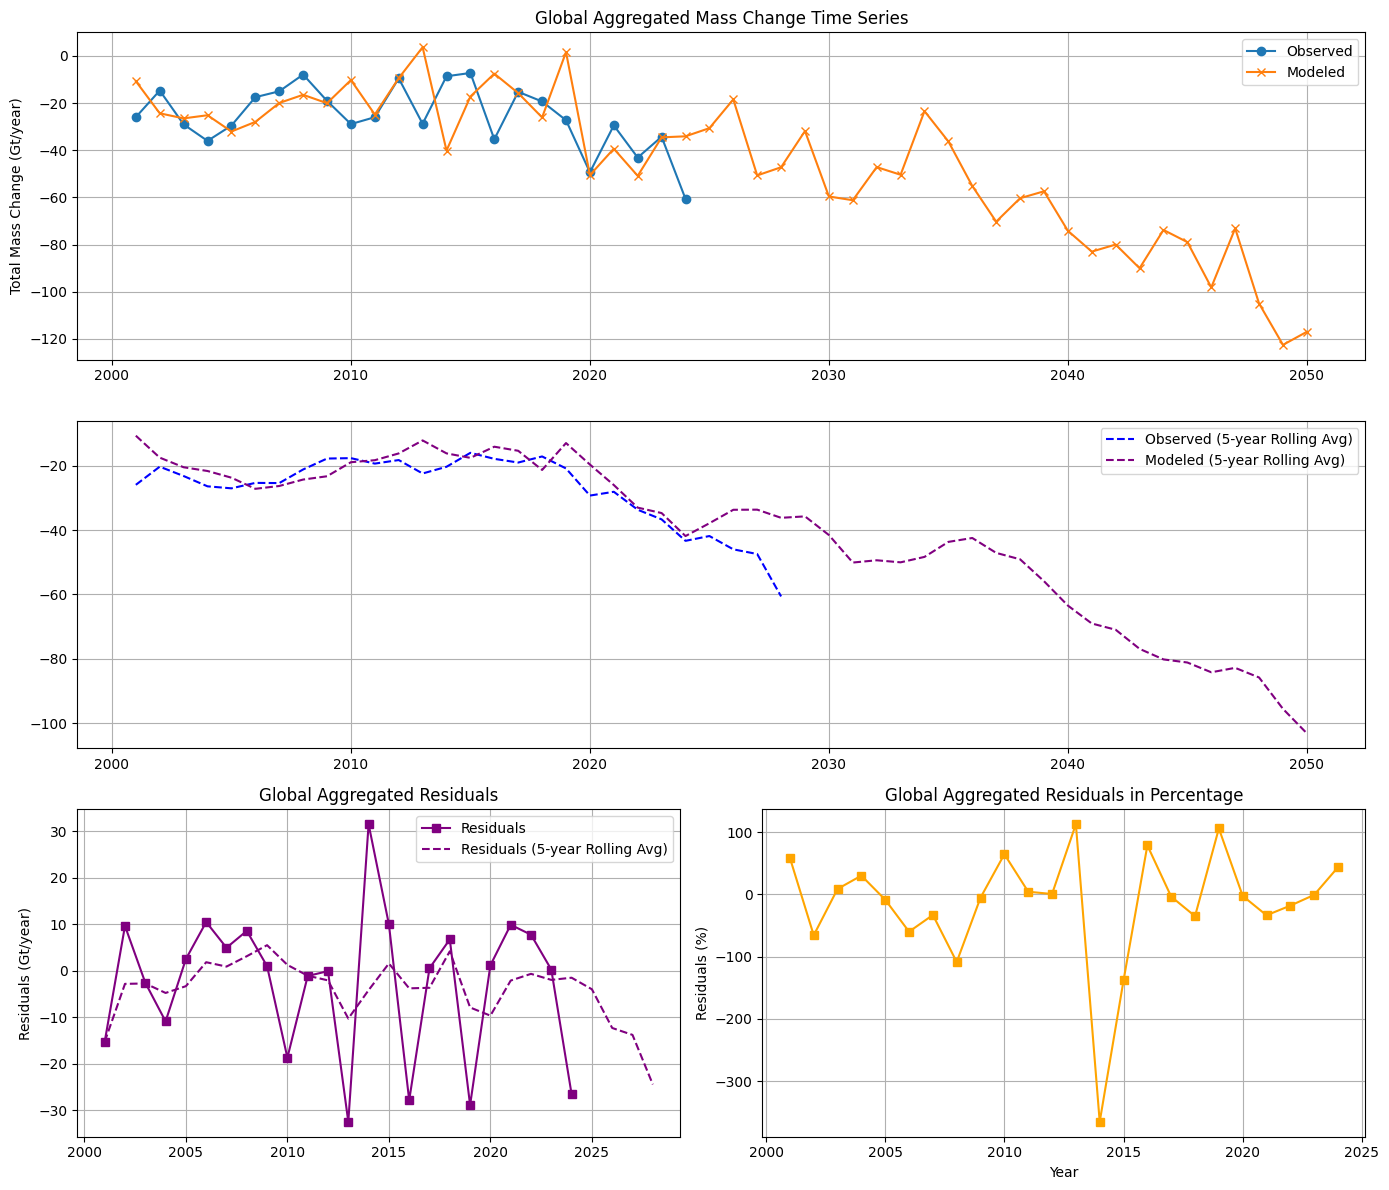

In [10]:
max_year = 2050  # Set the maximum year for the plot

# Global aggregated time series, residuals, and residuals in percentage plot 
if observation_dataset in ['Mass Change (Dussaillant, 2025, annual)', 'Mass Change (Hugonnet, 2021, 5-year period)']:
    # Aggregate model and observation values for all years
    model_sum = comparison_df.groupby('year')['model_value'].sum()
    obs_sum = comparison_df.groupby('year')['observation_value'].sum()

    # Build the global_agg DataFrame
    global_agg = pd.DataFrame({'year': all_years})
    global_agg['model_value'] = global_agg['year'].map(model_sum)
    global_agg['observation_value'] = global_agg['year'].map(obs_sum)

    global_agg.loc[~global_agg['year'].isin(obs_years), 'observation_value'] = np.nan
    global_agg.loc[~global_agg['year'].isin(model_years), 'model_value'] = np.nan
    

elif observation_dataset == 'Elevation Change (Hugonnet, 2021, 5-year period)':
    model_mean = comparison_df.groupby('year')['model_value'].mean()
    obs_mean = comparison_df.groupby('year')['observation_value'].mean()

    # Build the global_agg DataFrame
    global_agg = pd.DataFrame({'year': all_years})
    global_agg['model_value'] = global_agg['year'].map(model_mean)
    global_agg['observation_value'] = global_agg['year'].map(obs_mean)

    global_agg.loc[~global_agg['year'].isin(obs_mean.index), 'observation_value'] = np.nan
    global_agg.loc[~global_agg['year'].isin(model_mean.index), 'model_value'] = np.nan
    

global_agg['residual'] = global_agg['observation_value'] - global_agg['model_value']
global_agg['residual_percentage'] = global_agg['residual'] / global_agg['observation_value'] * 100

if observation_dataset == 'Mass Change (Dussaillant, 2025, annual)':
    common_years_dussaillant = sorted(set(global_agg['year'].dropna()) & set(global_agg.dropna(subset=['model_value'])['year']))
    plot_df = global_agg[global_agg['year'].isin(common_years_dussaillant)]
    plot_df['obs_rolling_avg_global']= plot_df["observation_value"].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    plot_df['model_rolling_avg_global'] = plot_df["model_value"].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    plot_df['res_rolling_avg_global'] = plot_df['obs_rolling_avg_global'] - plot_df['model_rolling_avg_global']

    plot_df = plot_df[plot_df['year'] <= max_year]

    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

    # Time series: Model vs Observed
    ax_ts = fig.add_subplot(gs[0, :])
    ax_ts.plot(plot_df['year'], plot_df['observation_value'], label='Observed', marker='o')
    ax_ts.plot(plot_df['year'], plot_df['model_value'], label='Modeled', marker='x')
    ax_ts.set_ylabel('Total Mass Change (Gt/year)')
    ax_ts.set_title('Global Aggregated Mass Change Time Series')
    ax_ts.legend()
    ax_ts.grid(True)

    # Rolling averages
    ax_rolling = fig.add_subplot(gs[1, :])
    ax_rolling.plot(plot_df['year'], plot_df['obs_rolling_avg_global'], label='Observed (5-year Rolling Avg)', linestyle='--', color='blue')
    ax_rolling.plot(plot_df['year'], plot_df['model_rolling_avg_global'], label='Modeled (5-year Rolling Avg)', linestyle='--', color='purple')
    ax_rolling.legend()
    ax_rolling.grid(True)

    # Residuals
    ax_res = fig.add_subplot(gs[2, 0])
    ax_res.plot(plot_df['year'], plot_df['residual'], color='purple', marker='s', label='Residuals')
    ax_res.plot(plot_df['year'], plot_df['res_rolling_avg_global'], color='purple', linestyle='--', label='Residuals (5-year Rolling Avg)')
    ax_res.set_ylabel('Residuals (Gt/year)')
    ax_res.set_title('Global Aggregated Residuals')
    ax_res.legend()
    ax_res.grid(True)

    # Residuals in Percentage
    ax_res_pct = fig.add_subplot(gs[2, 1])
    ax_res_pct.plot(plot_df['year'], plot_df['residual_percentage'], color='orange', marker='s')
    ax_res_pct.set_ylabel('Residuals (%)')
    ax_res_pct.set_title('Global Aggregated Residuals in Percentage')
    ax_res_pct.set_xlabel('Year')
    ax_res_pct.grid(True)

    plt.tight_layout()
    plt.show()

elif observation_dataset in ['Mass Change (Hugonnet, 2021, 5-year period)', 'Elevation Change (Hugonnet, 2021, 5-year period)']:
    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

    plot_df = global_agg[global_agg['year'] <= max_year]
    # Time series: Model vs Observed
    ax_ts = fig.add_subplot(gs[0, :])
    ax_ts.plot(plot_df['year'], plot_df['observation_value'], label='Observed', marker='o')
    ax_ts.plot(plot_df['year'], plot_df['model_value'], label='Modeled', marker='x')
    ax_ts.set_ylabel('Total Mass Change (Gt/year)')
    ax_ts.set_title('Global Aggregated Mass Change Time Series')
    ax_ts.legend()
    ax_ts.grid(True)

    # Residuals
    ax_res = fig.add_subplot(gs[1, 0])
    ax_res.plot(global_agg['year'], global_agg['residual'], color='purple', marker='s', label='Residuals')
    ax_res.set_ylabel('Residuals (Gt/year)')
    ax_res.set_title('Global Aggregated Residuals')
    ax_res.legend()
    ax_res.grid(True)

    # Residuals in Percentage
    ax_res_pct = fig.add_subplot(gs[1, 1])
    ax_res_pct.plot(global_agg['year'], global_agg['residual_percentage'], color='orange', marker='s')
    ax_res_pct.set_ylabel('Residuals (%)')
    ax_res_pct.set_title('Global Aggregated Residuals in Percentage')
    ax_res_pct.set_xlabel('Year')
    ax_res_pct.grid(True)

    plt.tight_layout()
    plt.show()

## Plot model diagnostics plots Per Region/glacier [9]
⭐️ In order to change the extent shown in the time series, change value for `max_year`.

❗️ The y-axis for the residuals plot are **not** the same. Note the difference in scale. 


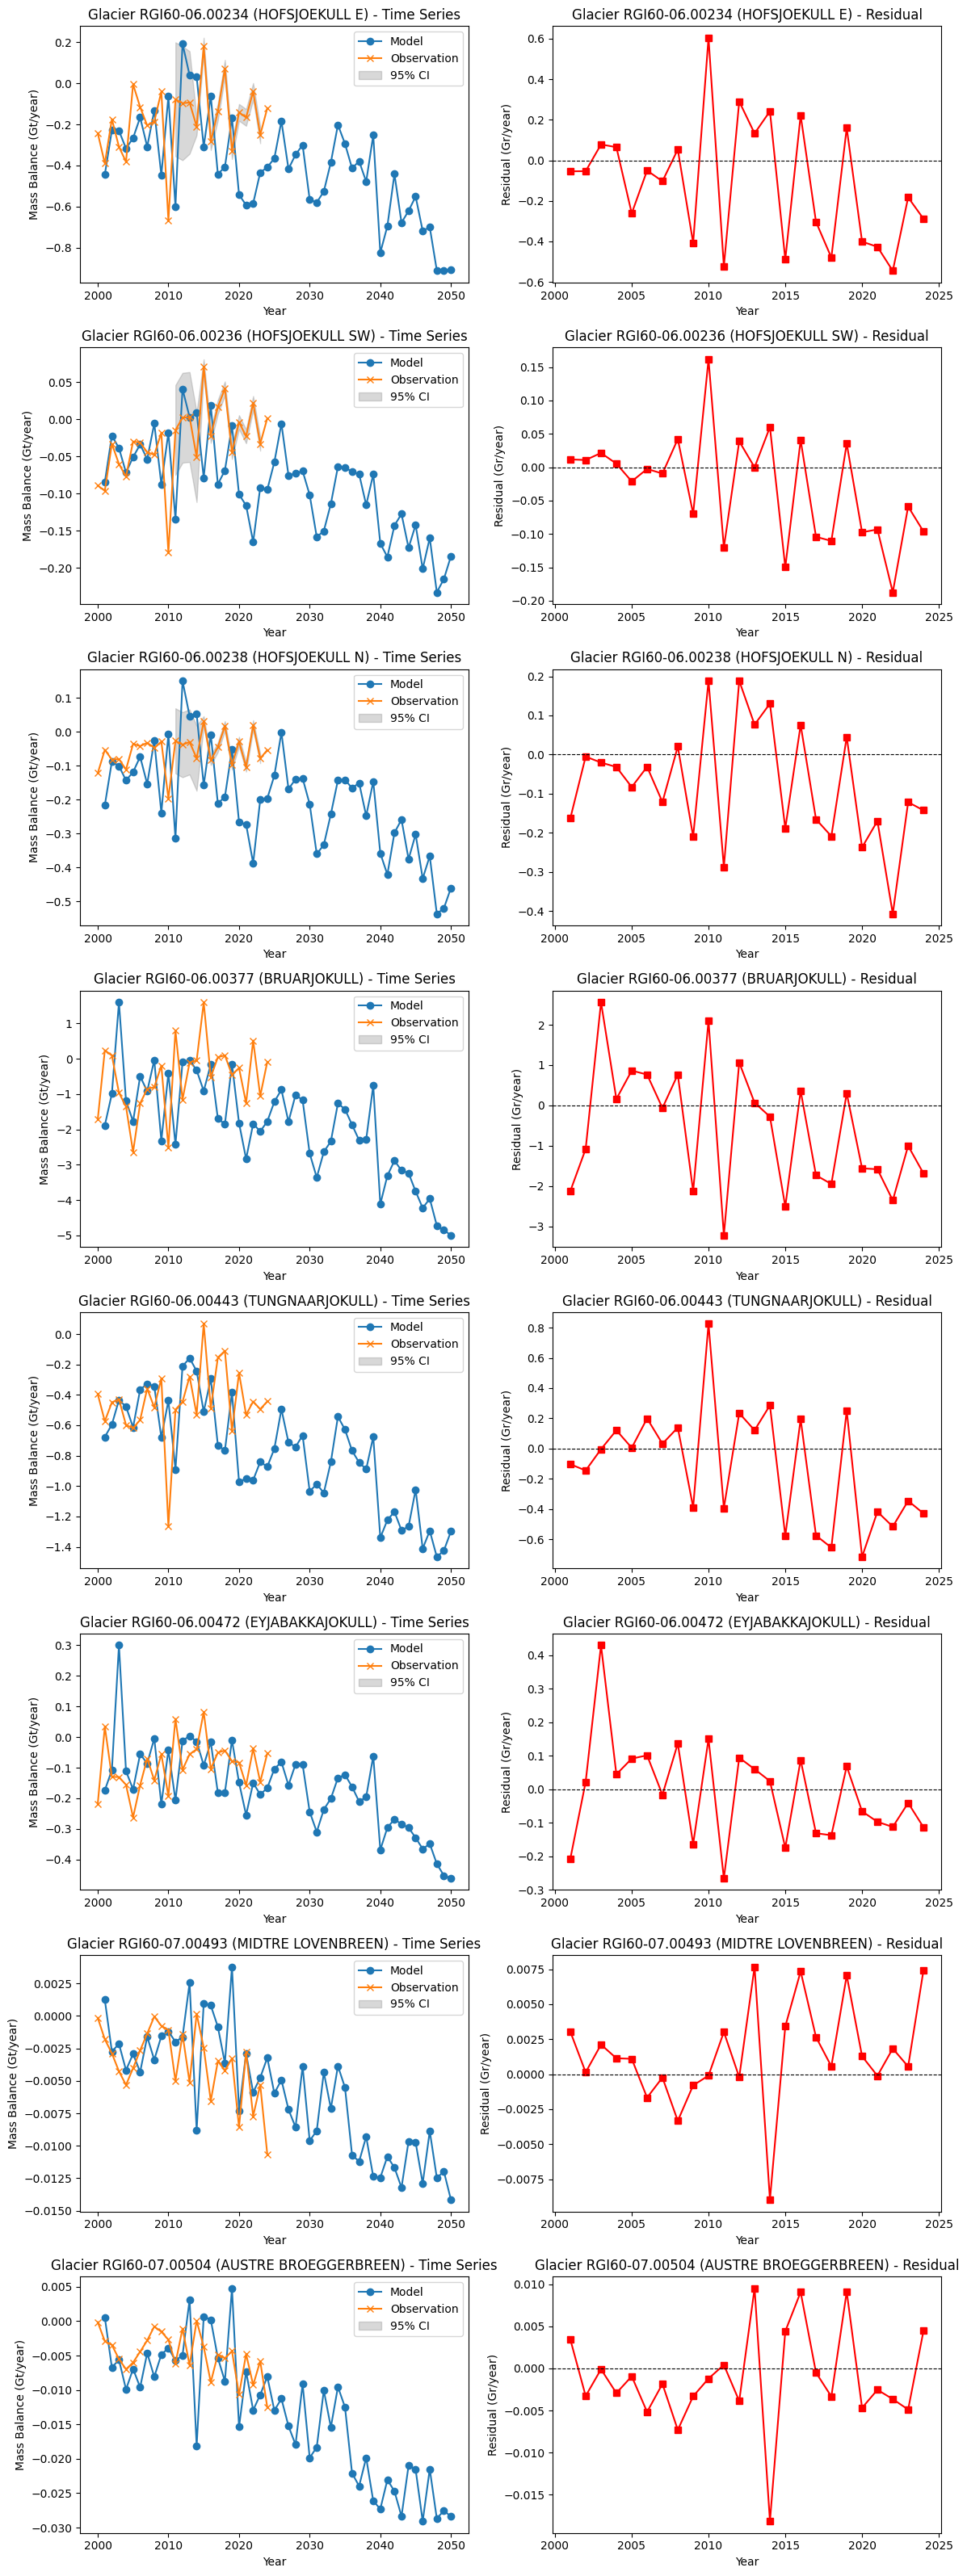

In [8]:
max_year = 2050  # Set the maximum year for the plot

if observation_dataset != 'Reference Glaciers':
    for rgi_id in selected_regions:
        # Filter for this region
        region_df = comparison_df[comparison_df["region"] == rgi_id]
        common_years_dussaillant = sorted(set(region_df['year'].dropna()) & set(region_df.dropna(subset=['model_value'])['year']))
        region_df = region_df[region_df['year'].isin(common_years_dussaillant)]
        region_df = region_df[region_df['year'] <= max_year]  
        if region_df.empty:
            print(f"No data for region {rgi_id}, skipping plot.")
            continue

        # Only use years where observation_value is not NaN
        all_years = region_df["year"].values
        model_values_full = region_df["model_value"].values
        model_rolling_avg = region_df["output_rolling_avg"].values if "output_rolling_avg" in region_df else None

        valid_mask = region_df["observation_value"].notnull()
        common_years = region_df.loc[valid_mask, "year"].values
        obs_values = region_df.loc[valid_mask, "observation_value"].values
        model_values = region_df.loc[valid_mask, "model_value"].values
        
        residuals = region_df.loc[valid_mask, "residual"].values
        residual_percentage = region_df.loc[valid_mask, "residual_percentage"].values
        
        ci_lower = region_df.loc[valid_mask, "ci_lower"].values if "ci_lower" in region_df else None
        ci_upper = region_df.loc[valid_mask, "ci_upper"].values if "ci_upper" in region_df else None
        obs_rolling_avg = region_df.loc[valid_mask, "obs_rolling_avg"].values if "obs_rolling_avg" in region_df else None
        residual_rolling_avg = region_df.loc[valid_mask, "residual_rolling_avg"].values if "residual_rolling_avg" in region_df else None
        rolling_CI_lower = region_df.loc[valid_mask, "rolling_CI_lower"].values if "rolling_CI_lower" in region_df else None
        rolling_CI_upper = region_df.loc[valid_mask, "rolling_CI_upper"].values if "rolling_CI_upper" in region_df else None

        # find global min and max for plotting
        global_min_res_pct = comparison_df['residual_percentage'].quantile(0.10)
        global_max_res_pct = comparison_df['residual_percentage'].quantile(0.90)

        fig = plt.figure(figsize=(14, 12))

        if observation_dataset == 'Mass Change (Dussaillant, 2025, annual)':
            gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1])

            fig.suptitle(f"Mass Change Comparison and Residual Diagnostics for Region {rgi_id}", fontsize=16)

            # Time Series Comparison (spans both columns in first row)
            ax_ts = fig.add_subplot(gs[0, :])
            ax_ts.plot(common_years, obs_values, label="Observed", marker='o')
            if ci_lower is not None and ci_upper is not None:
                ax_ts.fill_between(common_years, ci_lower, ci_upper, color='gray', alpha=0.3, label="95% CI")
            ax_ts.plot(all_years, model_values_full, label="Modeled", marker='x')
            ax_ts.set_title("Mass Change Time Series")
            ax_ts.set_ylabel("Gt/year")
            ax_ts.legend()
            ax_ts.grid(True)

            # Rolling averages
            ax_ts = fig.add_subplot(gs[1, :])
            if obs_rolling_avg is not None:
                ax_ts.plot(common_years, obs_rolling_avg, label="Observed (5-year Rolling Avg)", linestyle='--', color='blue')
            if rolling_CI_lower is not None and rolling_CI_upper is not None:
                ax_ts.fill_between(common_years, rolling_CI_lower, rolling_CI_upper, color='gray', alpha=0.3, label="95% CI (5-year Rolling Avg)")
            if model_rolling_avg is not None:
                ax_ts.plot(all_years, model_rolling_avg, label="Modeled (5-year Rolling Avg)", linestyle='--', color='purple')
            ax_ts.legend()
            ax_ts.grid(True)

            # Residuals
            ax_res = fig.add_subplot(gs[2, 0])
            ax_res.plot(common_years, residuals, color='purple', marker='s', label='Residuals')
            if residual_rolling_avg is not None:
                ax_res.plot(common_years, residual_rolling_avg, color='purple', linestyle='--', label='Residuals (5-year Rolling Avg)')
            ax_res.set_title("Residuals (Model - Observed)")
            ax_res.set_ylabel("Residuals")
            ax_res.legend()
            ax_res.grid(True)

            # Residuals in Percentage
            ax_res_pct = fig.add_subplot(gs[2, 1])
            ax_res_pct.plot(common_years, residual_percentage, color='orange', marker='s')
            ax_res_pct.set_ylim(global_min_res_pct, global_max_res_pct)
            ax_res_pct.set_title("Annual Residuals in Percentage")
            ax_res_pct.set_ylabel("Residuals (%)")
            ax_res_pct.grid(True)

            # Prepare RMSE data for all regions
            all_regions = comparison_df['region'].unique()
            rmse_by_region = (
                comparison_df.groupby('region')['rmse'].first().reindex(all_regions)
            )

            colors = ['tab:blue' if reg == rgi_id else 'gray' for reg in all_regions]
            alphas = [1.0 if reg == rgi_id else 0.4 for reg in all_regions]

            # RMSE bar plot
            ax_rmse = fig.add_subplot(gs[3, :])
            bars = ax_rmse.bar(all_regions, rmse_by_region, color=colors, alpha=1.0)
            for bar, alpha in zip(bars, alphas):
                bar.set_alpha(alpha)
            ax_rmse.set_xlabel('Region')
            ax_rmse.set_ylabel('RMSE')
            ax_rmse.set_title('RMSE by Region Calculated by Averaging Annual Values')

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
        elif observation_dataset in ['Mass Change (Hugonnet, 2021, 5-year period)', 'Elevation Change (Hugonnet, 2021, 5-year period)']:
            gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

            fig.suptitle(f"Mass Change Comparison and Residual Diagnostics for Region {rgi_id}", fontsize=16)

            # Time Series Comparison (spans both columns in first row)
            ax_ts = fig.add_subplot(gs[0, :])
            ax_ts.plot(common_years, obs_values, label="Observed", marker='o')
            ax_ts.plot(all_years, model_values_full, label="Modeled", marker='x')
            ax_ts.set_title("Mass Change Time Series")
            ax_ts.set_ylabel("Gt/year")
            ax_ts.legend()
            ax_ts.grid(True)

            # Residuals
            ax_res = fig.add_subplot(gs[1, 0])
            ax_res.plot(common_years, residuals, color='purple', marker='s', label='Residuals')
            ax_res.set_title("Residuals (Model - Observed)")
            ax_res.set_ylabel("Residuals")
            ax_res.legend()
            ax_res.grid(True)

            # Residuals in Percentage
            ax_res_pct = fig.add_subplot(gs[1, 1])
            ax_res_pct.plot(common_years, residual_percentage, color='orange', marker='s')
            ax_res_pct.set_ylim(global_min_res_pct, global_max_res_pct)
            ax_res_pct.set_title("Annual Residuals in Percentage")
            ax_res_pct.set_ylabel("Residuals (%)")
            ax_res_pct.grid(True)

            # Prepare RMSE data for all regions
            all_regions = comparison_df['region'].unique()
            rmse_by_region = (
                comparison_df.groupby('region')['rmse'].first().reindex(all_regions)
            )

            colors = ['tab:blue' if reg == rgi_id else 'gray' for reg in all_regions]
            alphas = [1.0 if reg == rgi_id else 0.4 for reg in all_regions]

            # RMSE bar plot
            ax_rmse = fig.add_subplot(gs[2, :])
            bars = ax_rmse.bar(all_regions, rmse_by_region, color=colors, alpha=1.0)
            for bar, alpha in zip(bars, alphas):
                bar.set_alpha(alpha)
            ax_rmse.set_xlabel('Region')
if observation_dataset == 'Reference Glaciers':
    # Get all unique glaciers
    glaciers = comparison_df['rgi_id'].unique()
    n_glaciers = len(glaciers)

    # Create a figure with 2 columns: Time series and Residuals
    fig, axes = plt.subplots(
        nrows=n_glaciers, ncols=2, figsize=(12, 4 * n_glaciers),
        sharex=False, squeeze=False
    )

    
    max_year = int(np.median(sorted(model_years)))  #can change
    comparison_df = comparison_df[comparison_df['year'] <= max_year]


    for i, gid in enumerate(sorted(glaciers)):
        # Filter data for this glacier
        glacier_df = comparison_df[comparison_df['rgi_id'] == gid]
        glacier_name = glacier_df['glacier_name'].dropna().iloc[0] if 'glacier_name' in glacier_df and glacier_df['glacier_name'].notnull().any() else gid

        # --- Left column: Model vs Observation ---
        axes[i, 0].plot(glacier_df['year'], glacier_df['dmdt_model'], label='Model', marker='o')
        axes[i, 0].plot(glacier_df['year'], glacier_df['dmdt_obs'], label='Observation', marker='x')
        axes[i, 0].fill_between(
            glacier_df['year'], glacier_df['dmdt_ci_lower'], glacier_df['dmdt_ci_upper'],
            color='gray', alpha=0.3, label='95% CI'
        )
        axes[i, 0].set_title(f"Glacier {gid} ({glacier_name}) - Time Series")
        axes[i, 0].set_ylabel("Mass Balance (Gt/year)")
        axes[i, 0].legend()

        # --- Right column: Residuals ---
        axes[i, 1].plot(glacier_df['year'], glacier_df['residual'], color='red', marker='s')
        axes[i, 1].axhline(0, color='black', linestyle='--', linewidth=0.8)
        axes[i, 1].set_title(f"Glacier {gid} ({glacier_name}) - Residual")
        axes[i, 1].set_ylabel("Residual (Gr/year)")
    
        # Set common X-label
        axes[i, 0].set_xlabel("Year")
        axes[i, 1].set_xlabel("Year")

    plt.tight_layout()
    plt.show()